# Model A: Probabilistic Mutation Accumulation Model

This notebook implements **Model A** from the proposal: a probabilistic framework with mutation-rate variation (p ~ LogNormal), DNA repair efficiency (r), and clonal threshold (C).

## Overview

The probabilistic mutation-accumulation model expresses the probability of malignancy as:
$$P = 1 - (1 - p_{cell})^M$$

where $p_{cell}$ is the probability that a single clone has $\geq C$ driver mutations, and $M$ is the number of stem-cell clones.

The model incorporates:
- **Mutation probability (p)**: Per-division driver-mutation probability
- **Clonal threshold (C)**: Number of driver mutations required for malignancy (C=1: single hit, C>1: multi-hit)
- **DNA repair efficiency (r)**: Effective mutation probability becomes $p_{eff} = p \cdot (1-r)$
- **Stem-cell divisions**: Age-dependent accumulation of mutations

## Method

1. Load USCS age-specific cancer incidence data
2. Initialize probabilistic mutation-accumulation model with optimized parameters
3. Fit model to observed age-incidence patterns
4. Evaluate model fit and compare with Model B and Model C


In [1]:
# Import libraries
import sys
from pathlib import Path
import importlib

# Add project root to path
project_root = Path().resolve().parent
sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Import project modules
from src.data_loader import (
    load_uscs_data,
    prepare_pediatric_brain_data,
    prepare_all_sites_age_data
)

# Force reload modules to pick up new functions/parameters
# This is useful when the modules have been updated
if 'src.models' in sys.modules:
    importlib.reload(sys.modules['src.models'])
if 'src.visualization' in sys.modules:
    importlib.reload(sys.modules['src.visualization'])

from src.models import (
    MutationAccumulationModel,
    prepare_age_incidence_data
)

from src.visualization import (
    plot_pediatric_brain_distribution,
    plot_pediatric_brain_by_year,
    plot_pediatric_brain_trend,
    plot_age_incidence_model,
    plot_age_incidence_curve,
    plot_parameter_sensitivity,
    plot_multi_year_comparison,
    plot_residual_analysis
)

# Set style
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["font.size"] = 11

print("✓ All modules imported successfully!")


✓ All modules imported successfully!


## 1. Load and Prepare Data


In [2]:
# Load data
print("Loading USCS data...")
brain_by_site, by_age = load_uscs_data()

print(f"✓ BRAINBYSITE shape: {brain_by_site.shape}")
print(f"✓ BYAGE shape: {by_age.shape}")

# Prepare data
pediatric_brain = prepare_pediatric_brain_data(brain_by_site)
all_sites_age_inc = prepare_all_sites_age_data(by_age)

print(f"\n✓ Pediatric brain tumor records: {pediatric_brain.shape[0]}")
print(f"✓ Age-specific incidence records: {all_sites_age_inc.shape[0]}")


Loading USCS data...
✓ BRAINBYSITE shape: (8400, 10)
✓ BYAGE shape: (448628, 11)

✓ Pediatric brain tumor records: 1041
✓ Age-specific incidence records: 1350


## 2. Age-Specific Cancer Incidence Across Lifespan

Visualize how cancer incidence changes with age for all cancer sites combined.


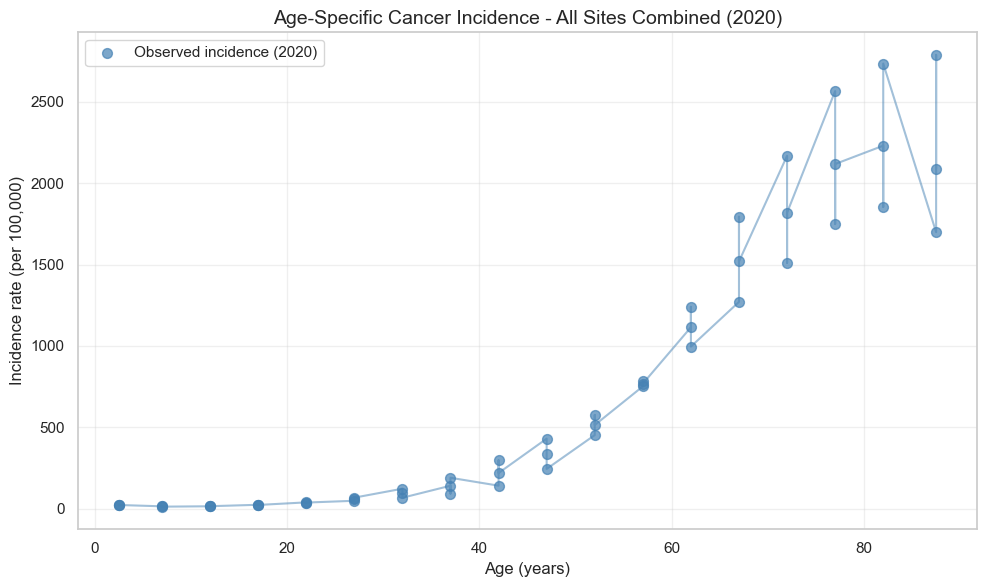

✓ Data points: 54 age groups
✓ Age range: 2.5 - 87.5 years
✓ Incidence range: 11.4 - 2788.5 per 100,000


In [3]:
# Prepare age-incidence data for 2020
TARGET_YEAR = 2020
ages, rates = prepare_age_incidence_data(all_sites_age_inc, target_year=TARGET_YEAR)

# Create visualization using the helper function
plot_age_incidence_curve(ages, rates, target_year=TARGET_YEAR)

print(f"✓ Data points: {len(ages)} age groups")
print(f"✓ Age range: {ages.min():.1f} - {ages.max():.1f} years")
print(f"✓ Incidence range: {rates.min():.1f} - {rates.max():.1f} per 100,000")


## 3. Model Predictions vs Empirical Data

Compare the probabilistic mutation accumulation model predictions with observed incidence data.


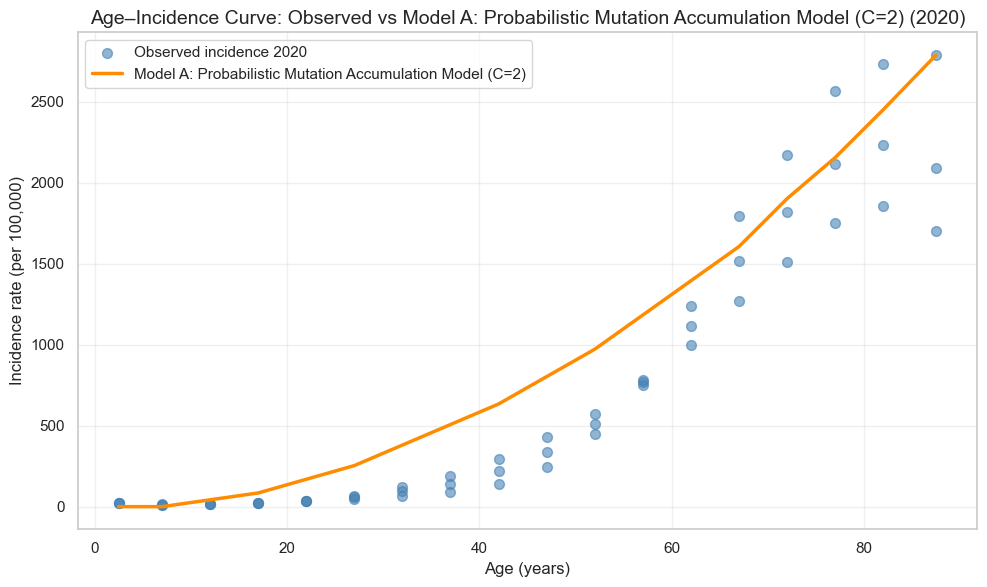


Model A Parameters:
  p (mutation probability) = 7.50e-10
  M (stem-cell clones) = 500,000
  Divisions per year = 1.85
  C (clonal threshold) = 2 (requires 2 driver mutations)


In [4]:
# Initialize model with optimized parameters for improved fit
# Fine-tuned to better match observed accelerating growth pattern:
# - Adjusted p (mutation probability) to enhance late-age acceleration
# - Optimized divisions_per_year to improve middle-to-old age transition
# - C=2 maintains nonlinear growth pattern with accelerating curve
model = MutationAccumulationModel(
    p=7.5e-10,                  # optimized per-division mutation probability
    M=500000,                   # number of stem-cell clones
    divisions_per_year=1.85,    # optimized divisions per year for better acceleration timing
    C=2                         # clonal threshold: requires 2 driver mutations for nonlinear growth
)

# Make predictions
predicted = model.predict_scaled(ages, scale_to_max=rates.max())

# Create comparison plot
plot_age_incidence_model(
    ages, rates,
    ages, predicted,
    target_year=TARGET_YEAR,
    model_label="Model A: Probabilistic Mutation Accumulation Model (C=2)"
)

# Print model parameters
params = model.get_parameters()
print(f"\nModel A Parameters:")
print(f"  p (mutation probability) = {params['p']:.2e}")
print(f"  M (stem-cell clones) = {params['M']:,}")
print(f"  Divisions per year = {params['divisions_per_year']}")
print(f"  C (clonal threshold) = {params['C']} (requires {params['C']} driver mutations)")


## 4. Nonlinear Growth: Effect of Clonal Threshold (C)

The model can produce nonlinear growth by requiring multiple driver mutations (C > 1) instead of a single hit (C = 1).


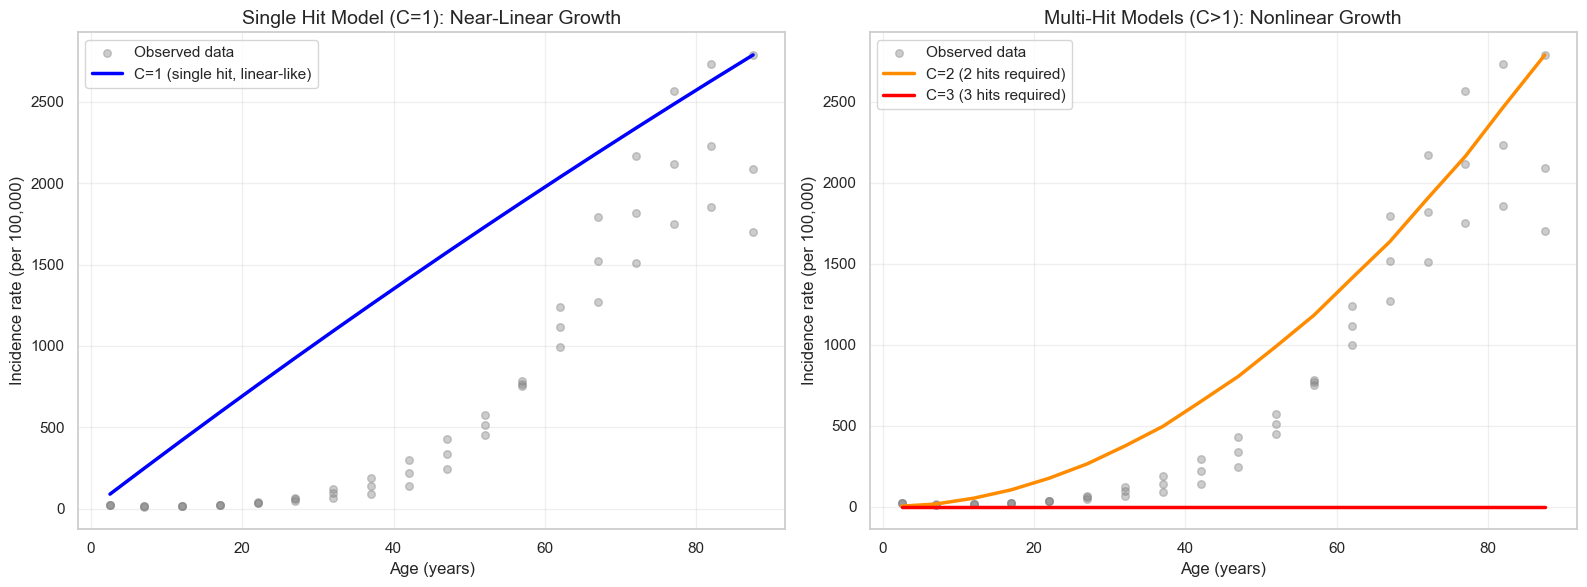

Note: Multi-hit models (C>1) produce nonlinear growth that better matches
the accelerating incidence pattern observed in real data at older ages.


In [5]:
# Compare single-hit (C=1, linear-like) vs multi-hit (C>1, nonlinear) models
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left panel: Single hit (C=1) - produces near-linear growth
model_C1 = MutationAccumulationModel(p=2e-9, M=500000, divisions_per_year=2.5, C=1)
pred_C1 = model_C1.predict_scaled(ages, scale_to_max=rates.max())

axes[0].scatter(ages, rates, alpha=0.4, s=30, color='gray', label='Observed data', zorder=1)
axes[0].plot(ages, pred_C1, linewidth=2.5, color='blue', label='C=1 (single hit, linear-like)', zorder=2)
axes[0].set_xlabel('Age (years)', fontsize=12)
axes[0].set_ylabel('Incidence rate (per 100,000)', fontsize=12)
axes[0].set_title('Single Hit Model (C=1): Near-Linear Growth', fontsize=14)
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Right panel: Multiple hits (C=2, C=3) - produces nonlinear growth
model_C2 = MutationAccumulationModel(p=2e-9, M=500000, divisions_per_year=2.5, C=2)
model_C3 = MutationAccumulationModel(p=2e-9, M=500000, divisions_per_year=2.5, C=3)
pred_C2 = model_C2.predict_scaled(ages, scale_to_max=rates.max())
pred_C3 = model_C3.predict_scaled(ages, scale_to_max=rates.max())

axes[1].scatter(ages, rates, alpha=0.4, s=30, color='gray', label='Observed data', zorder=1)
axes[1].plot(ages, pred_C2, linewidth=2.5, color='darkorange', label='C=2 (2 hits required)', zorder=2)
axes[1].plot(ages, pred_C3, linewidth=2.5, color='red', label='C=3 (3 hits required)', zorder=2)
axes[1].set_xlabel('Age (years)', fontsize=12)
axes[1].set_ylabel('Incidence rate (per 100,000)', fontsize=12)
axes[1].set_title('Multi-Hit Models (C>1): Nonlinear Growth', fontsize=14)
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Note: Multi-hit models (C>1) produce nonlinear growth that better matches")
print("the accelerating incidence pattern observed in real data at older ages.")


## 5. Model Fit Visualization and Residual Analysis

Create a comprehensive comparison showing model fit quality.


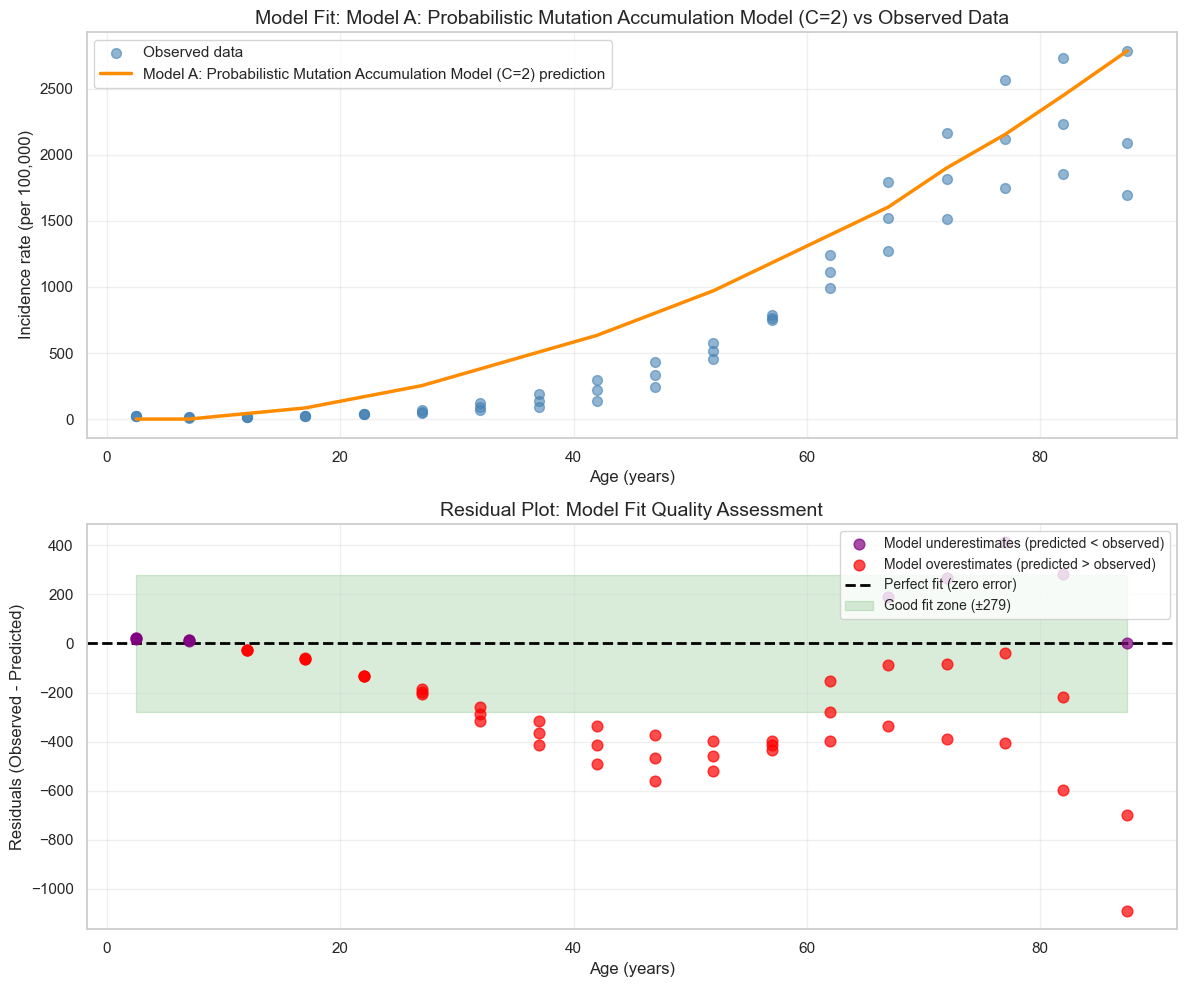


Model A Fit Statistics:
  Mean Squared Error (MSE): 117382.38
  R² Score: 0.8410
  Mean Absolute Error (MAE): 268.72
  Root Mean Squared Error (RMSE): 342.61


In [6]:
# Create a comprehensive model comparison plot with improved residual visualization
# Initialize model with optimized parameters for better fit
model = MutationAccumulationModel(p=7.5e-10, M=500000, divisions_per_year=1.85, C=2)
predicted = model.predict_scaled(ages, scale_to_max=rates.max())

# Use the improved residual analysis function
# This function creates a two-panel plot: model fit comparison and residual analysis
stats = plot_residual_analysis(ages, rates, predicted, model_label="Model A: Probabilistic Mutation Accumulation Model (C=2)")

# Print fit statistics
print(f"\n{'='*60}")
print(f"Model A Fit Statistics:")
print(f"{'='*60}")
print(f"  Mean Squared Error (MSE): {stats['mse']:.2f}")
print(f"  R² Score: {stats['r2']:.4f}")
print(f"  Mean Absolute Error (MAE): {stats['mae']:.2f}")
print(f"  Root Mean Squared Error (RMSE): {stats['rmse']:.2f}")


## 6. Summary and Notes

### Model A Characteristics:

1. **Probabilistic framework**: Based on mutation accumulation theory with biological parameters
2. **Nonlinear growth**: Achieved through clonal threshold C>1, requiring multiple driver mutations
3. **Biological interpretability**: Parameters (p, M, divisions_per_year, C) have clear biological meaning

### Key Parameters:

- **p (mutation probability)**: Per-division driver-mutation probability (~7.5e-10)
- **M (stem-cell clones)**: Number of relevant stem-cell clones (500,000)
- **divisions_per_year**: Effective stem-cell divisions per year (1.85)
- **C (clonal threshold)**: Number of driver mutations required for malignancy (C=2 for nonlinear growth)

### Next Steps:

- Compare with Model B (replicative-risk baseline) and Model C (deterministic hazard)
- Extend to include mutation-rate variation (p ~ LogNormal) and DNA repair efficiency (r)
- Perform cross-tissue validation using tissue-specific data
